In [1]:
import pathlib 
from repepo.variables import Environ
from repepo.experiments.cross_steering_result_db import CrossSteeringResultDatabase


# Read from db

import sqlite3
import pandas as pd
import functools

@functools.lru_cache(maxsize=1)
def load_df() -> pd.DataFrame:
    project_dir = pathlib.Path(Environ.ProjectDir)
    db = CrossSteeringResultDatabase(
        db_path = project_dir / "cross_steering_result.sqlite"
    )
    df = pd.read_sql_query(f"SELECT * FROM {db.name} WHERE steering_vector_dataset_name == 'believes-in-gun-rights'", db.con)
    return df

df = load_df()
print(len(df))

199500


# Inspect the results

In [2]:
# print number of null logit diff
print((df['test_example_logit_diff'] == "").sum())
# print number of null text
print((df['test_example_positive_text'] == "").sum())

0
171000


In [3]:
print(df['steering_vector_dataset_name'].unique())

['believes-in-gun-rights']


In [4]:
print(df.columns)

Index(['steering_vector_dataset_name', 'steering_vector_dataset_variant',
       'steering_vector_multiplier', 'test_dataset_name',
       'test_dataset_variant', 'test_example_id', 'test_example_positive_text',
       'test_example_negative_text', 'test_example_logit_diff',
       'test_example_pos_prob'],
      dtype='object')


<Axes: xlabel='test_example_id', ylabel='Count'>

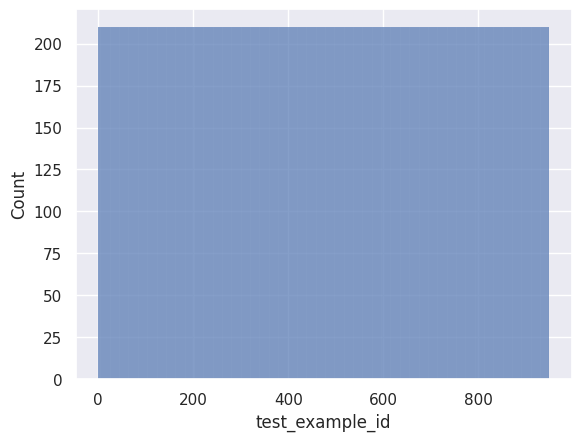

In [5]:
import seaborn as sns 
sns.set_theme()

sns.histplot(df, x='test_example_id', bins=950)

In [6]:
# Group by steering_vector_dataset_variant, test_example_id 
df_grouped = df.groupby([
    'steering_vector_dataset_name', 
    'steering_vector_dataset_variant', 
    'test_dataset_name',
    'test_dataset_variant',
    'test_example_id'
])

# Mean and variance of group sizes
group_sizes = df_grouped.size()
print(group_sizes.mean())
print(group_sizes.var())



7.0
0.0


# Steerability

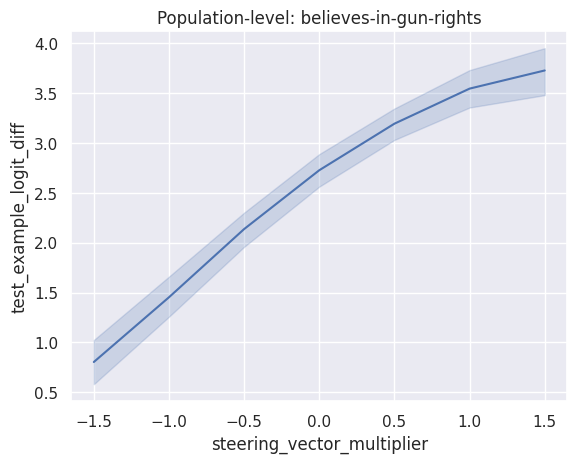

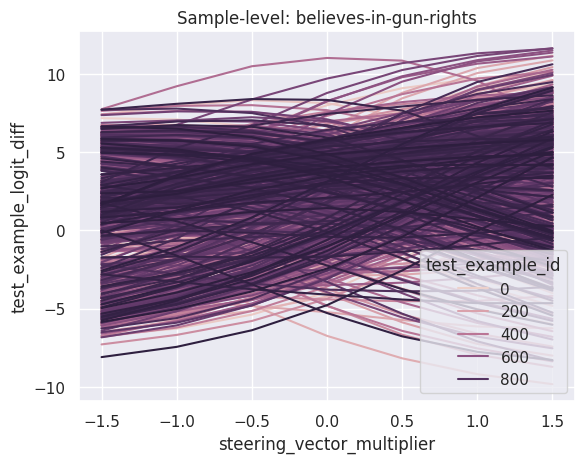

In [7]:
# Plot the logit diff vs the multiplier

# One line for full dataset
import matplotlib.pyplot as plt
ax = sns.lineplot(
    data=df[
        (df.test_dataset_variant == 'baseline') &
        (df.steering_vector_dataset_variant == 'baseline')
    ], 
    x='steering_vector_multiplier', 
    y='test_example_logit_diff', 
)
plt.title("Population-level: " + df['steering_vector_dataset_name'].unique()[0])
plt.show()

# One line for each test example
sns.lineplot(
    data=df[
        (df.test_dataset_variant == 'baseline') &
        (df.steering_vector_dataset_variant == 'baseline')
    ], 
    x='steering_vector_multiplier', 
    y='test_example_logit_diff', 
    hue='test_example_id'
)
plt.title("Sample-level: " + df['steering_vector_dataset_name'].unique()[0])
plt.show()

In [8]:
from repepo.steering.steerability import get_steerability_slope, get_steerabilty_spearman

# Compute steerability
group_columns = [
    'steering_vector_dataset_name', 
    'steering_vector_dataset_variant', 
    'test_dataset_name',
    'test_dataset_variant',
    'test_example_id'
]

def get_slope_df(group):
    # Extract the multipliers and propensities from the group
    multipliers = group['steering_vector_multiplier'].to_numpy()
    propensities = group['test_example_pos_prob'].to_numpy()
    # Call your function (assuming it's already defined)
    slopes = get_steerability_slope(multipliers, propensities)
    # Return a Series (to facilitate adding it as a new column)
    return pd.DataFrame(slopes, index=group.index, columns=['slope'])

grouped = load_df().groupby(group_columns)
df['slope'] = grouped.apply(get_slope_df).reset_index(level=group_columns, drop=True)

/tmp/ipykernel_1022450/489423682.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['slope'] = grouped.apply(get_slope_df).reset_index(level=group_columns, drop=True)


<Axes: xlabel='slope', ylabel='Count'>

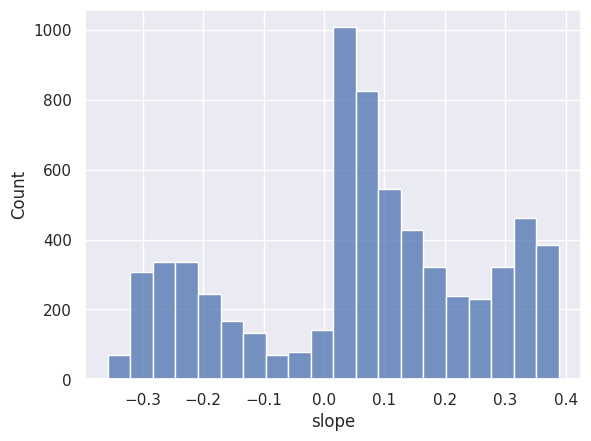

In [9]:
# histogram of slopes
sns.histplot(df[
    (df.test_dataset_variant == 'baseline') &
    (df.steering_vector_dataset_variant == 'baseline')
], x='slope', bins=20)

In [13]:
# Print the stdev of slopes
print(df[
    (df.test_dataset_variant == 'baseline') &
    (df.steering_vector_dataset_variant == 'baseline')
]['slope'].std())

0.1962577308473337


<Axes: xlabel='slope', ylabel='steering_vector_dataset_variant'>

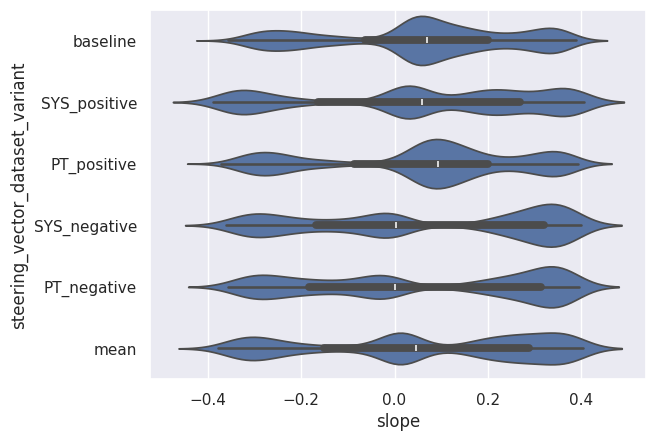

In [11]:
sns.violinplot(df[df.test_dataset_variant == 'baseline'], x='slope', y = 'steering_vector_dataset_variant')